# ESP Tutorial

In [1]:
%load_ext autoreload
%autoreload 2

import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=DeprecationWarning) 
import numpy as np
from qiskit.providers import BaseBackend
from qiskit.providers.models import QasmBackendConfiguration, PulseBackendConfiguration
from qiskit.result import Result
from qiskit.test import QiskitTestCase
from qiskit_experiments.measurement.discriminator import ESPDiscriminatorExperiment, ESPDiscriminatorAnalysis

## ESP Backend

In [6]:
class ESPDiscriminatorBackend(BaseBackend):
    """
    A simple backend that generates gaussian data for discriminator tests
    """

    def __init__(self):
        """
        Initialize the discriminator backend
        """
        configuration = PulseBackendConfiguration(
            backend_name="esp_discriminator_simulator",
            backend_version="0",
            n_qubits=int(1),
            basis_gates=["x", "id", "x_01_gate", "x_12_gate", "measure"],
            gates=[],
            local=True,
            simulator=True,
            conditional=False,
            open_pulse=True,
            memory=True,
            max_shots=8192,
            n_uchannels=0,
            u_channel_lo=[],
            meas_levels=[1, 2],
            qubit_lo_range=[[4.471852852405576, 5.471852852405577]],
            meas_lo_range=[[6.493370669000002, 7.493370669000002]],
            meas_kernels=['hw_boxcar'],
            discriminators=['quadratic_discriminator', 'linear_discriminator', 'esp_discriminator'],
            coupling_map=None,
            rep_times=[1000.0],
            dt=0.2222222222222222,
            dtm=0.2222222222222222,     
        )

        super().__init__(configuration)

    def sample_gaussian(
        self, centroid=np.array([0, 0]), cov=np.array([[0.1, 0], [0, 0.1]]), size=1
    ):
        """
        Draws random samples from a gaussian distribution.
        """
        return np.random.multivariate_normal(centroid, cov, size)

    # pylint: disable = arguments-differ
    def run(self, qobj):
        """
        Run the discriminator backend
        """

        shots = qobj.config.shots

        result = {
            "backend_name": "ESP discriminator backend",
            "backend_version": "0",
            "qobj_id": 0,
            "job_id": 0,
            "success": True,
            "results": [],
        }

        for circ in qobj.experiments:
            nqubits = circ.config.n_qubits
            centroids = np.zeros([nqubits, 2])
            counts = dict()
            memory = np.zeros([shots, circ.config.memory_slots, 2])

            for i in range(shots):
                clbits = np.zeros(circ.config.memory_slots, dtype=int)
                meas_res = 0
                for op in circ.instructions:
                    qubit = op.qubits[0]
                    if op.name == "x_01_gate":
                        meas_res = 1
                    elif op.name == 'x_12_gate':
                        meas_res = 2
                    elif op.name == "measure":
                        # centroid is either (0,0) for |0>, (1,1) for |1>, or (2,2) for |2>
                        memory[i, op.memory[0]] = self.sample_gaussian(
                            centroid=np.array([meas_res, meas_res])
                        )
                        clbits[op.memory[0]] = meas_res
                        
                clstr = ""
                for clbit in clbits[::-1]:
                    clstr = clstr + str(clbit)

                if clstr in counts:
                    counts[clstr] += 1
                else:
                    counts[clstr] = 1

            result["results"].append(
                {
                    "shots": shots,
                    "success": True,
                    "header": {"metadata": circ.header.metadata},
                    "data": {"counts": counts, "memory": memory},
                }
            )

        return Result.from_dict(result)

## FakeArmonk Backend - Single Qubit

/home/whatsis/Downloads/Honours/012_data/qiskit-experiments/qiskit_experiments/measurement/discriminator/esp_discriminator_experiment.py:306: UserWarning: Default PulseSimulator backend being built from FakeArmonk's system model.
  warnings.warn("Default PulseSimulator backend being built from FakeArmonk's system model.")


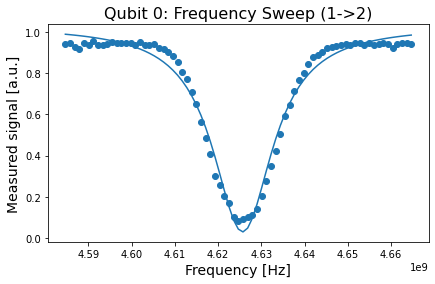

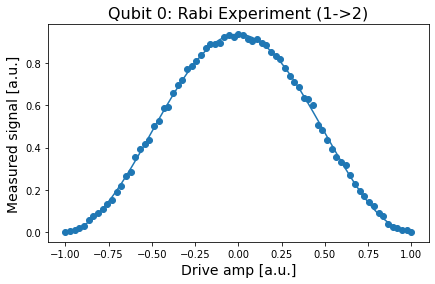

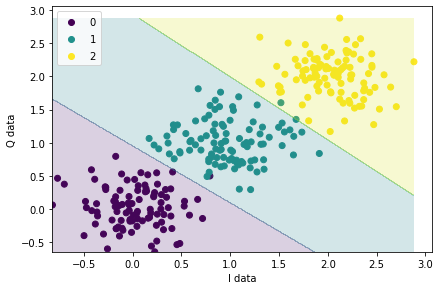

In [70]:
backend = ESPDiscriminatorBackend()
exp = ESPDiscriminatorExperiment(1)
res = exp.run(backend, shots=100, meas_level=1, meas_return="single").analysis_result(0)

## PulseSimulator Backend - Two Qubits

In [71]:
# The pulse simulator
from qiskit.providers.aer import PulseSimulator

# function for constructing duffing models
from qiskit.providers.aer.pulse import duffing_system_model

import qiskit.pulse as pulse
from qiskit.compiler import assemble
from qiskit.pulse import Play, ShiftPhase, Schedule, Waveform, ControlChannel, DriveChannel, AcquireChannel, MeasureChannel, MemorySlot
from qiskit.pulse.library import Gaussian, GaussianSquare
from qiskit.ignis.characterization.calibrations import rabi_schedules, RabiFitter

import matplotlib.pyplot as plt

In [72]:
# cutoff dimension
dim_oscillators = 5

# frequencies for transmon drift terms, harmonic term and anharmonic term
# Number of oscillators in the model is determined from len(oscillator_freqs)
oscillator_freqs = [5.0e9, 5.2e9]
anharm_freqs = [-0.33e9, -0.33e9]

# drive strengths
drive_strengths = [0.02e9, 0.02e9]

# specify coupling as a dictionary (qubits 0 and 1 are coupled with a coefficient 0.002e9)
coupling_dict = {(0,1): 0.002e9}

# sample duration for pulse instructions
dt = 1e-9

# create the model
two_qubit_model = duffing_system_model(dim_oscillators=dim_oscillators,
                                       oscillator_freqs=oscillator_freqs,
                                       anharm_freqs=anharm_freqs,
                                       drive_strengths=drive_strengths,
                                       coupling_dict=coupling_dict,
                                       dt=dt)

In [77]:
# list of qubits to be used throughout the notebook
qubits = [0, 1]

# Construct a measurement schedule and add it to an InstructionScheduleMap
meas_amp = 0.025
meas_samples = 1200
meas_sigma = 4
meas_width = 1150
meas_pulse = GaussianSquare(duration=meas_samples, amp=meas_amp,
                            sigma=meas_sigma, width=meas_width)


acq_sched = pulse.Acquire(meas_samples, pulse.AcquireChannel(0), pulse.MemorySlot(0))
acq_sched += pulse.Acquire(meas_samples, pulse.AcquireChannel(1), pulse.MemorySlot(1))

measure_sched = pulse.Play(meas_pulse, pulse.MeasureChannel(0)) | pulse.Play(meas_pulse, pulse.MeasureChannel(1)) | acq_sched

inst_map = pulse.InstructionScheduleMap()
inst_map.add('measure', qubits, measure_sched)

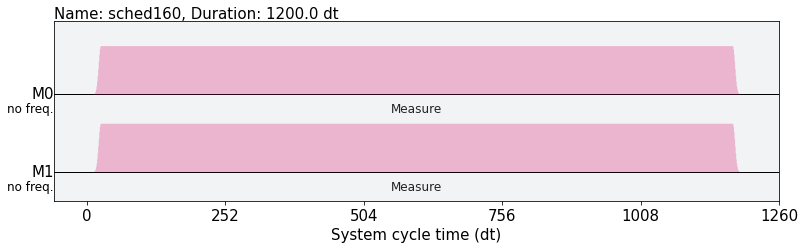

In [78]:
measure_sched.draw()

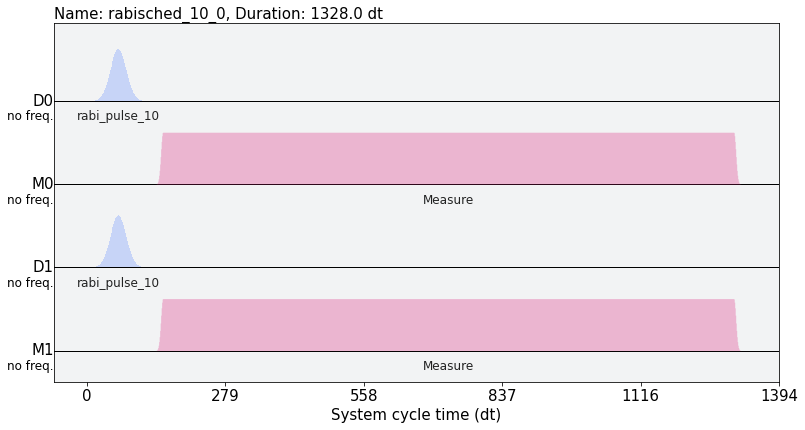

In [79]:
# construct Rabi experiments
drive_amps = np.linspace(0, 0.9, 48)
drive_sigma = 16
drive_duration = 128
drive_channels = [pulse.DriveChannel(0), pulse.DriveChannel(1)]


rabi_experiments, rabi_amps = rabi_schedules(amp_list=drive_amps,
                                             qubits=qubits,
                                             pulse_width=drive_duration,
                                             pulse_sigma=drive_sigma,
                                             drives=drive_channels,
                                             inst_map=inst_map,
                                             meas_map=[[0, 1]])
rabi_experiments[10].draw()

In [80]:
# instantiate the pulse simulator
backend_sim = PulseSimulator()

# compute frequencies from the Hamiltonian
qubit_lo_freq = two_qubit_model.hamiltonian.get_qubit_lo_from_drift()

rabi_qobj = assemble(rabi_experiments,
                     backend=backend_sim,
                     qubit_lo_freq=qubit_lo_freq,
                     meas_level=1,
                     meas_return='avg',
                     shots=1024)

# run the simulation
rabi_result = backend_sim.run(rabi_qobj, two_qubit_model).result()

<ipython-input-80-8531d7c1eb30>:15: DeprecationWarning: Passing `system_model` as a positional argument to `PulseSimulator.run` has been deprecated as of qiskit-aer 0.7.0 and will be removed no earlier than 3 months from that release date. Pass `system_model` as a kwarg `system_model=model` instead.
  rabi_result = backend_sim.run(rabi_qobj, two_qubit_model).result()


Pi Amp: 0.622938
Pi Amp: 0.624177


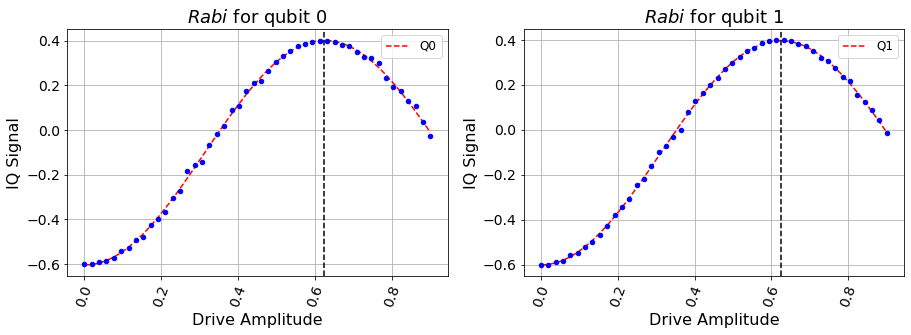

In [81]:
rabifit = RabiFitter(rabi_result, rabi_amps, qubits, fit_p0 = [0.5,0.5,0.6,1.5])

plt.figure(figsize=(15, 10))
q_offset = 0
qubit_lo_amp = []
for qubit in qubits:
    ax = plt.subplot(2, 2, qubit + 1)
    rabifit.plot(qubit, ax=ax)
    qubit_lo_amp.append(rabifit.pi_amplitude(qubit))
    print('Pi Amp: %f'%rabifit.pi_amplitude(qubit))
plt.show()

In [82]:
x_sched_01 = []
for qubit in qubits:
    sched = pulse.Schedule(name=f"0->1 pulse schedule")
    x_01_pulse = Gaussian(duration = drive_duration, amp = qubit_lo_amp[qubit],
                            sigma = drive_sigma, name = 'x_01_pulse')
    sched |= pulse.Play(x_01_pulse, pulse.DriveChannel(qubit))
    inst_map.add('x', qubit, sched)
    x_sched_01.append(sched)

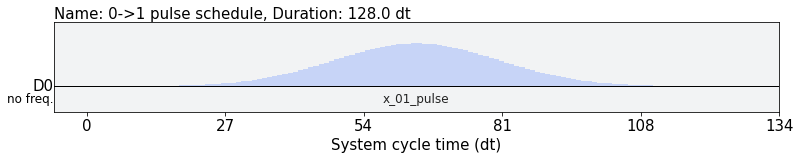

In [83]:
x_sched_01[0].draw()

In [84]:
backend = ESPDiscriminatorBackend()
exp = ESPDiscriminatorExperiment(2)

In [85]:
exp.backend = PulseSimulator()
exp.backend_model = two_qubit_model
exp.dt = dt
exp.frequency_estimates = qubit_lo_freq
exp.anharmonicity_estimates = anharm_freqs
exp.inst_map = inst_map

### Default Discriminator: LDA

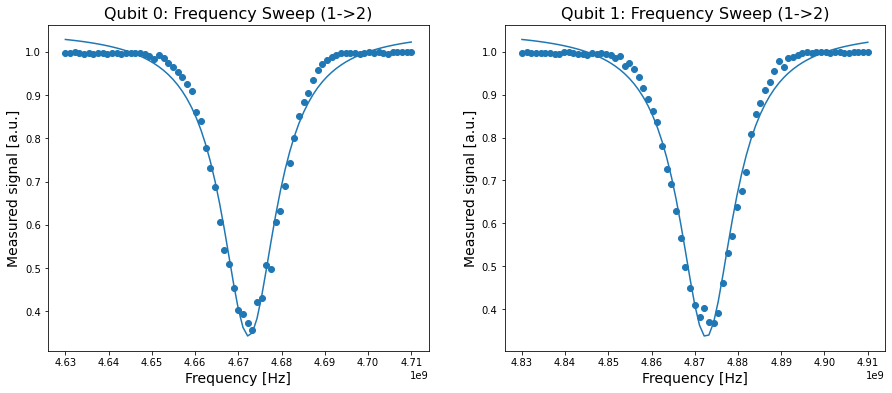

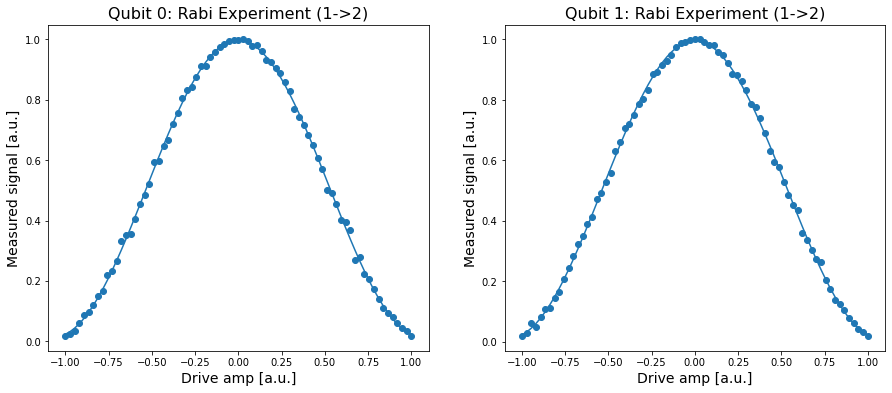

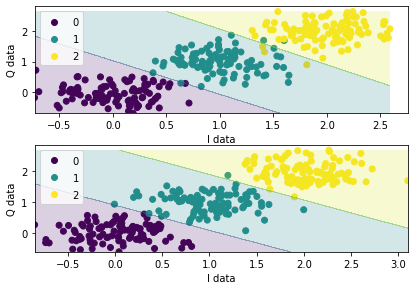

In [86]:
res = exp.run(backend, shots=100, meas_level=1, meas_return="single").analysis_result(0)

### Secondary Discriminator - QDA

{'discriminator': [LinearDiscriminantAnalysis()],
 'coef': [array([[ -8.19720564, -11.51103725],
         [ -0.19027879,  -0.03861964],
         [  8.38748443,  11.54965688]])],
 'intercept': [array([  9.54587862,  -0.86826674, -31.43371021])],
 'score': [0.99],
 'plt': [<AxesSubplot:xlabel='I data', ylabel='Q data'>],
 'success': True}

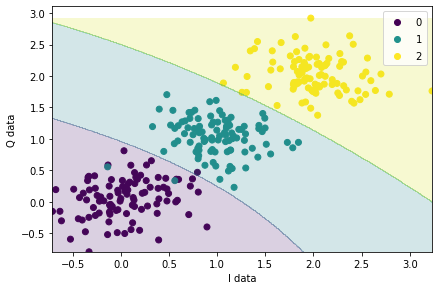

In [105]:
exp.run_analysis(res,  discriminator_type="QDA").analysis_result(0)

### SkLearn-based discriminator

/home/whatsis/Downloads/Honours/012_data/qiskit-experiments/qiskit_experiments/base_analysis.py:91: RuntimeWarning: Expected sklearn classifier object to be passed,
                                      instead KNeighborsClassifier(metric='manhattan', n_neighbors=50) provided. The default 
                                      is set to KNeighborsClassifier(metric='manhattan', n_neighbors=50).
  analysis_results, figures = self._run_analysis(experiment_data, **analysis_options)


{'discriminator': [LinearDiscriminantAnalysis()],
 'coef': [array([[ -8.19720564, -11.51103725],
         [ -0.19027879,  -0.03861964],
         [  8.38748443,  11.54965688]])],
 'intercept': [array([  9.54587862,  -0.86826674, -31.43371021])],
 'score': [0.99],
 'plt': [<AxesSubplot:xlabel='I data', ylabel='Q data'>],
 'success': True}

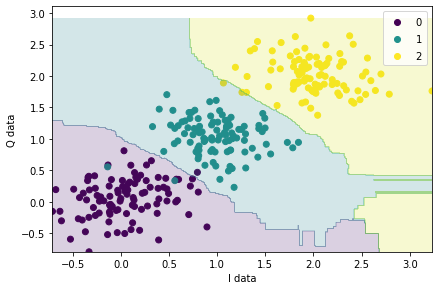

In [104]:
exp.run_analysis(res,  discriminator_type="sklearn").analysis_result(0)